# Downloading data

In [1]:
import torch

# Other files
import utils
from models.autowarp import AutoWarp
from models.mean_variance_optimisation import MeanVarianceOptimisation
from models.autoencoders import LinearAutoencoder, ConvAutoencoder, ConvLinearAutoEncoder, train_autoencoder, get_distance_matrix

# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Optimisation
from pypfopt.expected_returns import mean_historical_return

import yfinance as yf

# Set seed for reproducibility
torch.manual_seed(0);

C:\Users\roryc\miniconda3\envs\metric_learning_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
valid_date = '2018-06-01'
train_date = '2020-01-01'

prices_train, _, _, prices_test = utils.split_prices(train_date=train_date, valid_date=valid_date)
data_train, _, _, _ = utils.split_orbis_data(train_date=train_date, valid_date=valid_date, returns=True, momentum=True)

In [3]:
# S&P 500
sp500 = yf.download("^GSPC", start=train_date, end="2022-09-30", period="1d")['Adj Close']
sp500 = sp500.div(sp500.iloc[0]).mul(100)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Dict for matrices
params = {'Linear': {}, 'CNN': {}, 'Linear + CNN': {}}

params['Linear']['autoencoder'] = {'latent_size': 45, 'hidden_size': 282, 'batch_size': 18}
params['Linear']['dist_matrix'] = {'distance_metric': 'euclidean', 'gamma':  0.6692836288735067, 'latent_size': 45}
params['Linear']['risk_matrix'] = {'C': -0.5335323890859849}
params['Linear']['optimiser'] = {'l2_reg': 0}

params['CNN']['autoencoder'] = {'latent_size': 38, 'hidden_size': 292, 'batch_size': 27}
params['CNN']['dist_matrix'] = {'distance_metric': 'euclidean', 'gamma': 0.2895826467161696, 'latent_size': 38}
params['CNN']['risk_matrix'] = {'C': -0.41643980400603453}
params['CNN']['optimiser'] = {'l2_reg': 0}

params['Linear + CNN']['autoencoder'] = {'hidden_size': 294, 'hidden_size2': 256,'latent_size': 9, 'batch_size': 18}
params['Linear + CNN']['dist_matrix'] = {'gamma': 0.7951039163451445, 'latent_size': 9, 'distance_metric': 'euclidean'}
params['Linear + CNN']['risk_matrix'] = {'C': -0.5704179594746961}
params['Linear + CNN']['optimiser'] = {'l2_reg': 0}

num_epochs=20

# Calculating distance matrix

In [5]:
models = {}
models['Linear'] = train_autoencoder(LinearAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear']['autoencoder'])
models['CNN'] = train_autoencoder(ConvAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['CNN']['autoencoder'])
models['Linear + CNN'] =train_autoencoder(ConvLinearAutoEncoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear + CNN']['autoencoder'])

LinearAutoencoder
Epoch [1/20], Loss: 0.1122
Epoch [2/20], Loss: 0.0333
Epoch [3/20], Loss: 0.0277
Epoch [4/20], Loss: 0.0256
Epoch [5/20], Loss: 0.0223
Epoch [6/20], Loss: 0.0190
Epoch [7/20], Loss: 0.0158
Epoch [8/20], Loss: 0.0135
Epoch [9/20], Loss: 0.0122
Epoch [10/20], Loss: 0.0110
Epoch [11/20], Loss: 0.0100
Epoch [12/20], Loss: 0.0086
Epoch [13/20], Loss: 0.0077
Epoch [14/20], Loss: 0.0068
Epoch [15/20], Loss: 0.0060
Epoch [16/20], Loss: 0.0055
Epoch [17/20], Loss: 0.0050
Epoch [18/20], Loss: 0.0045
Epoch [19/20], Loss: 0.0041
Epoch [20/20], Loss: 0.0038
ConvAutoencoder
Epoch [1/20], Loss: 0.1840
Epoch [2/20], Loss: 0.1429
Epoch [3/20], Loss: 0.0759
Epoch [4/20], Loss: 0.0670
Epoch [5/20], Loss: 0.0599
Epoch [6/20], Loss: 0.0490
Epoch [7/20], Loss: 0.0387
Epoch [8/20], Loss: 0.0338
Epoch [9/20], Loss: 0.0319
Epoch [10/20], Loss: 0.0312
Epoch [11/20], Loss: 0.0307
Epoch [12/20], Loss: 0.0302
Epoch [13/20], Loss: 0.0299
Epoch [14/20], Loss: 0.0294
Epoch [15/20], Loss: 0.0287
Epoc

In [6]:
%time
dist_matrices = {}
for model in ['Linear', 'Linear + CNN', 'CNN']:
#for model in ['CNN']:
    # if model == 'CNN': # currently very slow for CNN, TBC why
    #     dist_matrices[model] = get_distance_matrix(models[model], data_train, **params[model]['dist_matrix'])
    # else:
    learner = AutoWarp(models[model], data_train, latent_size=params[model]['autoencoder']['latent_size'], p=0.5, max_iterations=10, batch_size=25, lr=0.1)
    learner.learn_metric()
    dist_matrices[model] = learner.create_distance_matrix()

CPU times: total: 0 ns
Wall time: 0 ns
alpha tensor([0.4301], requires_grad=True)
gamma tensor([0.2252], requires_grad=True)
epsilon tensor(1.0118, requires_grad=True)
alpha tensor([0.2252], requires_grad=True)
gamma tensor(1.0118, requires_grad=True)
epsilon tensor(0.9518, requires_grad=True)
alpha tensor(1.0118, requires_grad=True)
gamma tensor(0.9518, requires_grad=True)
epsilon tensor(0.8742, requires_grad=True)
alpha tensor(0.9518, requires_grad=True)
gamma tensor(0.8742, requires_grad=True)
epsilon tensor(0.9854, requires_grad=True)
alpha tensor(0.8742, requires_grad=True)
gamma tensor(0.9854, requires_grad=True)
epsilon tensor(0.7753, requires_grad=True)
alpha tensor(0.9854, requires_grad=True)
gamma tensor(0.7753, requires_grad=True)
epsilon tensor(0.9449, requires_grad=True)
alpha tensor(0.7753, requires_grad=True)
gamma tensor(0.9449, requires_grad=True)
epsilon tensor(0.8300, requires_grad=True)
alpha tensor(0.9449, requires_grad=True)
gamma tensor(0.8300, requires_grad=True

# Mean variance optimisation

In [7]:
# Empty dict for weights
weights = {}

for model in ["Linear", "CNN", "Linear + CNN"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    risk_matrix = optimiser.make_risk_matrix(dist_matrices[model], **params[model]['risk_matrix'])
    weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, rf_rate=0.02, **params[model]['optimiser'])

    # Print out summary
    print(model, train_sr)

#for model in ["Covariance", "Covariance Shrinkage", "Exponentially weighted Covariance"]:
for model in ["Covariance", "Covariance Shrinkage"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        risk_matrix = optimiser.benchmark_matrix(model)
        weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, rf_rate=0.02, l2_reg=0)

    # Print out summary
    print(model, train_sr)

# Equal weights
weights['Equal'] = weights['Linear'].copy()
weights['Equal']['weights'] = 1/weights['Linear']['weights'].shape[0]
print("Equal", utils.calculate_sharpe_ratio(weights=weights['Equal'], prices=prices_train, rf_rate=0.02))

Linear 1.7124098775425354
CNN 1.415902660867429
Linear + CNN 1.1032030968534297
Covariance 2.4473905235972016
Covariance Shrinkage 2.446068571127526
Equal 1.0728860221350591


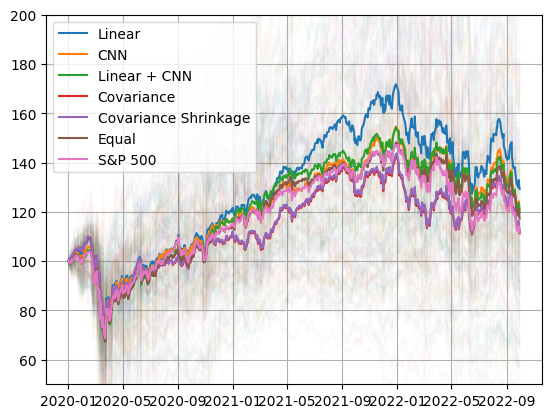

In [8]:
# Plots
plt.plot(prices_test, alpha=0.025)
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
#for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage"]:
    plt.plot(prices_test @ weights[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.grid()
plt.legend();

In [9]:
# Sharpe ratios
rf = 0.02

for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
    print(model, "sharpe",  utils.calculate_sharpe_ratio(prices = prices_test, weights = weights[model], rf_rate = rf))
    #print(model, "std",utils.calculate_sd(prices = prices_test, weights = weights[model]))

sp500_returns =((sp500/sp500.shift(1))-1).dropna()
avg_return = sp500_returns.mean() * 252
std = sp500_returns.std() * np.sqrt(252)
sharpe = (avg_return - 0.02) / std
print("S&P 500", sharpe)

Linear sharpe 0.4102839708800272
CNN sharpe 0.3228498136489697
Linear + CNN sharpe 0.30696436985318026
Covariance sharpe 0.20718426695207298
Covariance Shrinkage sharpe 0.21535984607553751
Equal sharpe 0.27722415574076253
S&P 500 0.20868407278075438


In [10]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage"]:
    print(model, "number of stocks included:", np.count_nonzero(weights[model]))

Linear number of stocks included: 37
CNN number of stocks included: 47
Linear + CNN number of stocks included: 164
Covariance number of stocks included: 15
Covariance Shrinkage number of stocks included: 17


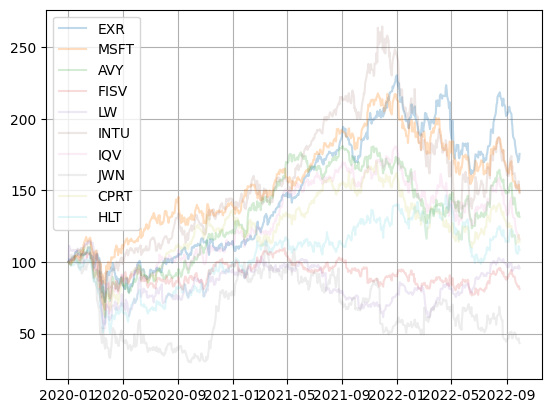

In [11]:
# Plot performance of CNN stocks
for i in weights['Linear'].sort_values(by='weights', ascending=False).head(10).index:
    plt.plot(prices_test[i], label=i, alpha=min(weights['Linear'].loc[i, 'weights']*3, 1))
plt.legend()
plt.grid();

# HRP

In [12]:
from models.hrp import HRPOpt
rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)
hrp.optimize(dist_matrix=dist_matrices['Linear'])
weights_hrp = hrp.clean_weights()

C:\Users\roryc\Documents\_Git\portfolio_metric_learning\models\hrp.py:172: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  self.clusters = sch.linkage(dist, linkage_method)


In [13]:
weights_hrp = pd.DataFrame.from_dict(weights_hrp, orient='index', columns=['weights'])

In [14]:
# Empty dict for weights
weights_hrp = {}

rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)

for model in ["Linear", "CNN", "Linear + CNN"]:

    hrp.optimize(dist_matrix=-dist_matrices[model])
    weights_hrp[model] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])

hrp.optimize()
weights_hrp['Benchmark'] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])

# Equal weights
weights_hrp['Equal'] = weights_hrp['Linear'].copy()
weights_hrp['Equal']['weights'] = 1/weights_hrp['Linear']['weights'].shape[0]

In [15]:
# Sharpe ratios
rf = 0.02

for model in ["Linear", "CNN", "Linear + CNN", "Benchmark", "Equal"]:
    print(model, utils.calculate_sharpe_ratio(prices = prices_test, weights = weights_hrp[model], rf_rate = rf))

Linear 0.2616619571645562
CNN 0.2640895967727606
Linear + CNN 0.25980365666337496
Benchmark 0.2547977891679829
Equal 0.27722415574076253


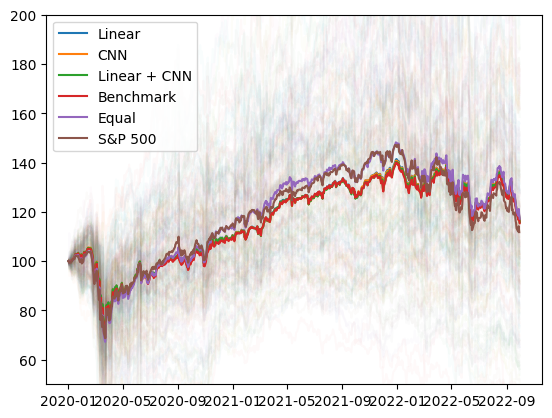

In [16]:
# Plots
plt.plot(prices_test, alpha=0.025)
for model in ["Linear", "CNN", "Linear + CNN", "Benchmark", "Equal"]:
    plt.plot(prices_test @ weights_hrp[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.legend();

In [17]:
for model in ["Linear", "CNN", "Linear + CNN", "Benchmark"]:
    print(model, "number of stocks included:", np.count_nonzero(weights_hrp[model]))

Linear number of stocks included: 200
CNN number of stocks included: 200
Linear + CNN number of stocks included: 200
Benchmark number of stocks included: 200
